In [3]:
suppressPackageStartupMessages({
  library(tidyverse)
  library(reticulate)
  library(GenomicRanges)
  library(tmpRpkg)
  library(ComplexHeatmap)
  #library(magick)
})
# change the size of figures shown in jupyter
options(repr.plot.width=15, repr.plot.height=8)
Sys.setenv("_R_USE_PIPEBIND_" = TRUE)



In [2]:
# meta
projd <- here::here()
hmd <- file.path(projd, "10.superEnhancer", "out", "heatmap")
supenhd <- file.path(projd, "10.superEnhancer", "out", "ROSE_H3K27me3")
scs <- list.files(supenhd, full.names = FALSE, no.. = TRUE, all.files = FALSE)

In [5]:
# functions
loadSuperEnhancer <- function(sc) {
    data.table::fread(
        file = file.path(supenhd, sc, str_glue("{sc}_AllStitched.table.txt")),
        head = TRUE, sep = "\t", skip = "#", data.table = FALSE
    )
}

In [ ]:
# load super enhancers
supenhl <- lapply(scs, loadSuperEnhancer) |>
  setNames(object = _, nm = scs)



In [7]:
flatEnhs <- do.call(rbind, supenhl)
flatEnhs$sc <- do.call("c", lapply(scs, \(sc) {
  rep(sc, nrow(supenhl[[sc]]))
}))
flatSuperEnhs <- flatEnhs[flatEnhs$isSuper > 0, ]
rownames(flatSuperEnhs) <- with(
  flatSuperEnhs,
  paste(sc,
    paste(CHROM, paste(START, STOP, sep = "-"), sep = ":"),
    sep = "@")
)


In [8]:
str(flatEnhs)
message("Only Super Enhancers identified by ROSE:")
str(flatSuperEnhs)

'data.frame':	4624647 obs. of  10 variables:
 $ REGION_ID       : chr  "9_CRE_lociStitched" "8_CRE_lociStitched" "8_CRE_lociStitched" "8_CRE_lociStitched" ...
 $ CHROM           : chr  "chr5" "chr5" "chr9" "chr7" ...
 $ START           : int  119791465 119641135 107386921 49615600 40708444 184720243 24931876 63297459 190158697 34861728 ...
 $ STOP            : int  119842614 119686752 107443655 49677536 40743702 184738552 24955834 63327653 190199782 34912191 ...
 $ NUM_LOCI        : int  9 8 8 8 7 6 6 6 6 6 ...
 $ CONSTITUENT_SIZE: int  7245 5286 4991 7266 4535 2535 4485 3379 3998 4112 ...
 $ H3K27me3.srt.bam: num  43344 34460 34460 34460 29289 ...
 $ stitchedPeakRank: int  1 2 3 4 5 6 7 8 9 10 ...
 $ isSuper         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ sc              : chr  "001_CLA_EPd_CTX_Car3_Glut" "001_CLA_EPd_CTX_Car3_Glut" "001_CLA_EPd_CTX_Car3_Glut" "001_CLA_EPd_CTX_Car3_Glut" ...


Only Super Enhancers identified by ROSE:



'data.frame':	176741 obs. of  10 variables:
 $ REGION_ID       : chr  "9_CRE_lociStitched" "8_CRE_lociStitched" "8_CRE_lociStitched" "8_CRE_lociStitched" ...
 $ CHROM           : chr  "chr5" "chr5" "chr9" "chr7" ...
 $ START           : int  119791465 119641135 107386921 49615600 40708444 184720243 24931876 63297459 190158697 34861728 ...
 $ STOP            : int  119842614 119686752 107443655 49677536 40743702 184738552 24955834 63327653 190199782 34912191 ...
 $ NUM_LOCI        : int  9 8 8 8 7 6 6 6 6 6 ...
 $ CONSTITUENT_SIZE: int  7245 5286 4991 7266 4535 2535 4485 3379 3998 4112 ...
 $ H3K27me3.srt.bam: num  43344 34460 34460 34460 29289 ...
 $ stitchedPeakRank: int  1 2 3 4 5 6 7 8 9 10 ...
 $ isSuper         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ sc              : chr  "001_CLA_EPd_CTX_Car3_Glut" "001_CLA_EPd_CTX_Car3_Glut" "001_CLA_EPd_CTX_Car3_Glut" "001_CLA_EPd_CTX_Car3_Glut" ...


In [9]:
length(unique(with(flatSuperEnhs, paste(CHROM, 
                                        paste(START, STOP, sep = "-"),
                                       sep = ":"))))

[1] 163716

In [10]:
# prepare H3K27me3 signals on these super enhancers (in another R script)
K27acAllSE <- readRDS(
    file.path(hmd, "signalH3K27me3.allsuperEnhancer.scList.rds"))

In [11]:
allSEmat <- do.call(rbind, K27acAllSE)
colnames(allSEmat) <- rownames(flatSuperEnhs)
str(allSEmat)

 num [1:187, 1:176741] 6.42 6.24 4.86 4.38 4.01 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:187] "001_CLA_EPd_CTX_Car3_Glut" "002_IT_EP_CLA_Glut" "003_L5_6_IT_TPE_ENT_Glut" "004_L6_IT_CTX_Glut" ...
  ..$ : chr [1:176741] "001_CLA_EPd_CTX_Car3_Glut@chr5:119791465-119842614" "001_CLA_EPd_CTX_Car3_Glut@chr5:119641135-119686752" "001_CLA_EPd_CTX_Car3_Glut@chr9:107386921-107443655" "001_CLA_EPd_CTX_Car3_Glut@chr7:49615600-49677536" ...


In [12]:
quantile(rowSums(allSEmat))
rowNormAllSEmat <- (allSEmat * 10^5) / rowSums(allSEmat)
str(rowNormAllSEmat)
scaleAllSEmat <- scale(rowNormAllSEmat, center = TRUE, scale = TRUE)
str(scaleAllSEmat)

# remove supertype from subclass
sel_scs <- scs[vapply(scs, \(sc) {
    strsplit(sc, "_", fixed = TRUE) |> 
    unlist() |>
    x => as.integer(x[1])
}, 1L) < 500]
str(sel_scs)


0%      25%      50%      75%     100% 
313411.9 365762.8 391225.3 425178.4 567713.0

 num [1:187, 1:176741] 1.68 1.61 1.33 1.28 1.17 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:187] "001_CLA_EPd_CTX_Car3_Glut" "002_IT_EP_CLA_Glut" "003_L5_6_IT_TPE_ENT_Glut" "004_L6_IT_CTX_Glut" ...
  ..$ : chr [1:176741] "001_CLA_EPd_CTX_Car3_Glut@chr5:119791465-119842614" "001_CLA_EPd_CTX_Car3_Glut@chr5:119641135-119686752" "001_CLA_EPd_CTX_Car3_Glut@chr9:107386921-107443655" "001_CLA_EPd_CTX_Car3_Glut@chr7:49615600-49677536" ...
 num [1:187, 1:176741] 0.1346 -0.0787 -0.9913 -1.1526 -1.5153 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:187] "001_CLA_EPd_CTX_Car3_Glut" "002_IT_EP_CLA_Glut" "003_L5_6_IT_TPE_ENT_Glut" "004_L6_IT_CTX_Glut" ...
  ..$ : chr [1:176741] "001_CLA_EPd_CTX_Car3_Glut@chr5:119791465-119842614" "001_CLA_EPd_CTX_Car3_Glut@chr5:119641135-119686752" "001_CLA_EPd_CTX_Car3_Glut@chr9:107386921-107443655" "001_CLA_EPd_CTX_Car3_Glut@chr7:49615600-49677536" ...
 - attr(*, "scaled:center")= Named num [1:176741] 1.634 1.462 0.49 0.996 1.809 ...
  ..- attr(*, "na

In [13]:
# downsample superEnhancers per sc to reduce the size of heatmap
nds <- 200
selSupEnhs <- lapply(sel_scs,
    \(sc) {
        e <- colnames(scaleAllSEmat)
        ind <- grepl(sc, e, fixed = TRUE)
        if (sum(ind) < 1) {
            message("No super enhancers found for ", sc)
            return(NULL)
        }
        e <- e[ind]
        a <- scaleAllSEmat[sc, e]
        r <- e[order(a, decreasing = TRUE)][1:min(nds, length(e))]
        return(r)
    }
) |> 
x => Filter(\(l) {!is.null(l)}, x) |>
x => do.call("c", x)

In [14]:
p_ds <- Heatmap(scaleAllSEmat[sel_scs[!grepl("070_LSX_Prdm12_Slit2_Gaba", sel_scs)], selSupEnhs], 
                name = "H3K27ac signals on super enhancers identified by ROSE",
                cluster_rows = FALSE, show_row_dend = FALSE, show_row_names = FALSE,
                cluster_columns = FALSE, show_column_dend = FALSE, show_column_names = FALSE,
                show_heatmap_legend = TRUE,
                heatmap_legend_param = list(title = "Scaled Signals Per 10K"),
                use_raster = TRUE)

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



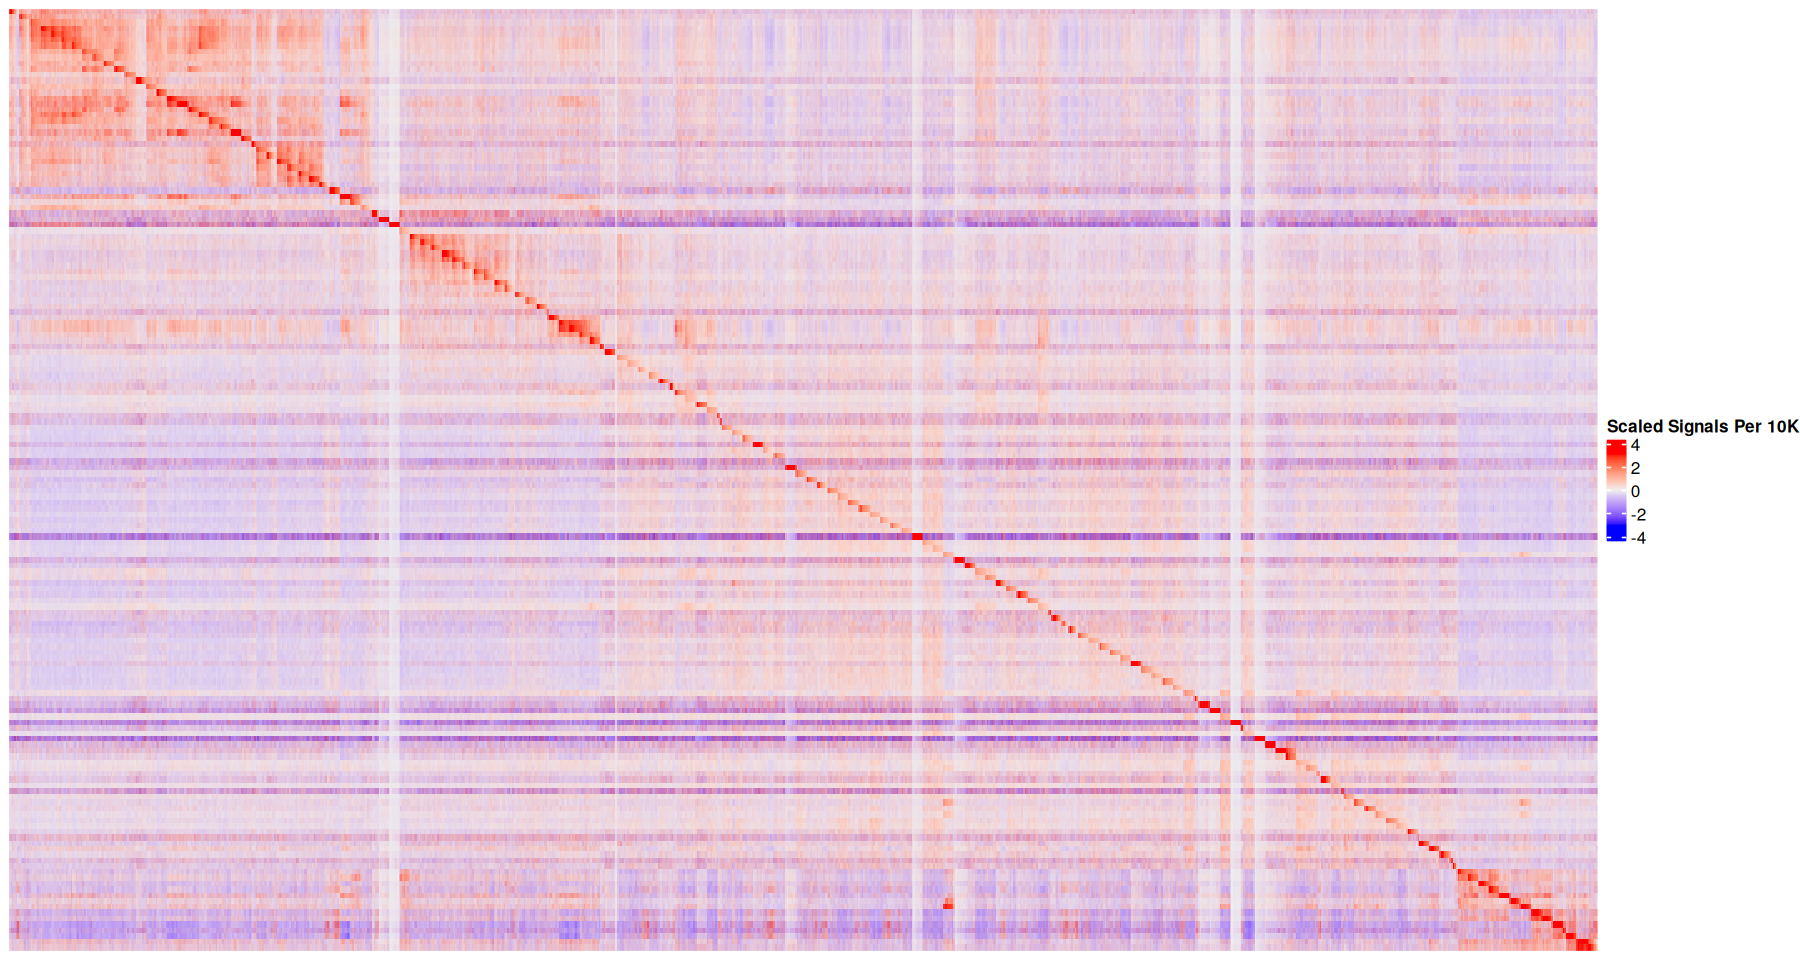

In [15]:
draw(p_ds, heatmap_legend_side = "right")